In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import cv2
import os
import shutil
import yaml
import json
import torch
from lib.utils import *

from random import randint
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
%matplotlib inline

In [2]:
input_data_path = ''
output_path = os.getcwd()
df = pd.read_csv(os.path.join(input_data_path, 'data/train_solution_bounding_boxes (1).csv'))
df.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764800,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020261,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


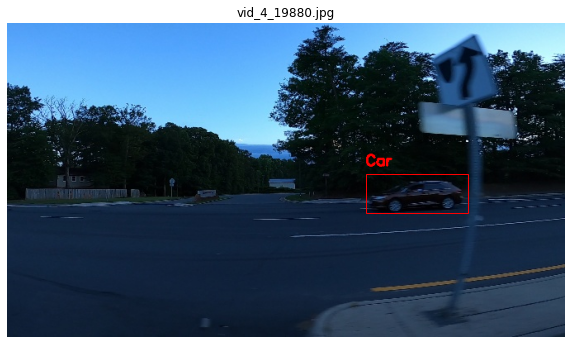

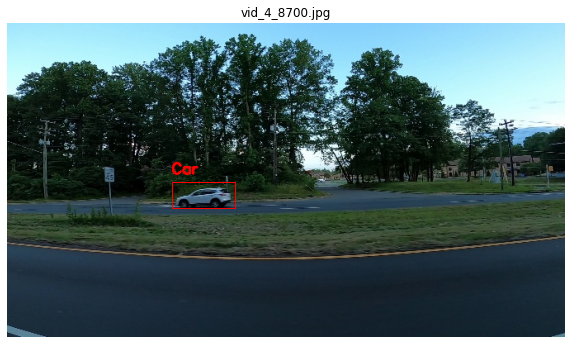

In [3]:
df1 = df.copy()
df1['class'] = 0
df1['bboxes'] = df1[['xmin', 'ymin', 'xmax', 'ymax']].apply(list, axis=1)
df1 = df1.drop(columns=['xmin', 'ymin', 'xmax', 'ymax']).groupby('image', as_index=False).agg(list)


def draw_img_with_box(df_index):
    img = cv2.imread(os.path.join(input_data_path, 'data', 'training_images', df1.loc[df_index, 'image']))
    img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
    fig, ax = plt.subplots(figsize=(10, 10))
    boxes = df1.loc[df_index, 'bboxes']
    for bbox in boxes:
        rect = patches.Rectangle((int(bbox[0]), int(bbox[1])), int(bbox[2]) - int(bbox[0]), int(bbox[3]) - int(bbox[1]),
                                 linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        cv2.putText(img, 'Car', (int(bbox[0]), int(bbox[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
    ax.imshow(img)
    plt.title(df1.loc[df_index, 'image'])
    ax.axis('off')
    plt.show()


for _ in range(2):
    draw_img_with_box(randint(0, len(df1)))

In [4]:
def get_width_and_height(img_path):
    img = cv2.imread(img_path)
    height, width, _ = img.shape
    return height, width


def convert_to_yolo_bbox(bbox, w, h):
    x_center = ((bbox[2] + bbox[0]) / 2) / w
    y_center = ((bbox[3] + bbox[1]) / 2) / h
    width = (bbox[2] - bbox[0]) / w
    height = (bbox[3] - bbox[1]) / h
    return x_center, y_center, width, height
    

def make_df(df):
    images_names, bbox_x, bbox_y, bbox_width, bbox_height = [], [], [], [], []
    imgsNames_height, imgsNames_width = {}, {}
    dataframe = pd.DataFrame()
    for _, data in df.iterrows():
        row = data.to_list()
        height, width = get_width_and_height(os.path.join(input_data_path, 'data', 'training_images', row[0]))
        x_center, y_center, width_bbox, height_bbox = convert_to_yolo_bbox(row[1:], width, height)
        images_names.append(row[0])
        bbox_x.append(x_center)
        bbox_y.append(y_center)
        bbox_width.append(width_bbox)
        bbox_height.append(height_bbox)
        imgsNames_width[row[0]] = width
        imgsNames_height[row[0]] = height
    dataframe['image'] = images_names
    dataframe['bbox_x'] = bbox_x
    dataframe['bbox_y'] = bbox_y
    dataframe['bbox_width'] = bbox_width
    dataframe['bbox_height'] = bbox_height
    dataframe['class'] = 0
    dataframe['bboxes'] = dataframe[['bbox_x', 'bbox_y', 'bbox_width', 'bbox_height']].apply(list, axis=1)
    dataframe = dataframe.drop(columns=['bbox_x', 'bbox_y', 'bbox_width', 'bbox_height']).groupby('image', as_index=False).agg(list)
    dataframe['height'] = imgsNames_height.values()
    dataframe['width'] = imgsNames_width.values()
    return dataframe

df_yolo = make_df(df)
df_yolo.head()

,image,class,bboxes,height,width
0,vid_4_1000.jpg,[0],"[[0.4504341534023668, 0.5398166023684211, 0.06...",380,676
1,vid_4_10000.jpg,[0],"[[0.10021707670857986, 0.5571911197368421, 0.1...",380,676
2,vid_4_10020.jpg,[0],"[[0.8332127352071007, 0.5314510939473683, 0.19...",380,676
3,vid_4_10040.jpg,[0],"[[0.44464544142011836, 0.5436776061842105, 0.1...",380,676
4,vid_4_10060.jpg,[0],"[[0.11034732271449704, 0.5591216215789474, 0.1...",380,676


In [5]:
train_df, val_df = train_test_split(df_yolo, test_size=0.2)

train_images_names = train_df.image.to_list()
val_images_names = val_df.image.to_list()

In [6]:
data_path = os.path.join(output_path, 'yolov7', 'car_detect')

train_path = os.path.join(data_path, 'train')
train_images_path = os.path.join(train_path, 'images')
train_labels_path = os.path.join(train_path, 'labels')

val_path = os.path.join(data_path, 'val')
val_images_path = os.path.join(val_path, 'images')
val_labels_path = os.path.join(val_path, 'labels')

test_img_path_start = os.path.join(input_data_path, 'data', 'testing_images')
test_img_path = os.path.join(output_path, 'test_images')
test_img_names = os.listdir(test_img_path_start)

if not os.path.isdir(data_path):
    os.mkdir(data_path)

if not os.path.isdir(train_path):
    os.mkdir(train_path)
if not os.path.isdir(train_images_path):
    os.mkdir(train_images_path)
if not os.path.isdir(train_labels_path):
    os.mkdir(train_labels_path)

if not os.path.isdir(val_path):
    os.mkdir(val_path)
if not os.path.isdir(val_images_path):
    os.mkdir(val_images_path)
if not os.path.isdir(val_labels_path):
    os.mkdir(val_labels_path)
    
if not os.path.isdir(test_img_path):
    os.mkdir(test_img_path)
    
    
for img in train_images_names:
    shutil.copy(os.path.join(input_data_path, 'data', 'training_images', img), train_images_path)

for img in val_images_names:
    shutil.copy(os.path.join(input_data_path, 'data', 'training_images', img), val_images_path)
    
for img in test_img_names:
    shutil.copy(os.path.join(test_img_path_start, img), test_img_path)
    


In [7]:
def make_labels_files(df, label_path):
    for _, row in df.iterrows():
        with open(f"{os.path.join(label_path, row['image'][:-3])}txt", 'w') as file:
            text = ''
            for line in list(zip(row['class'], row['bboxes'])):
                text += f'{line[0]} {line[1][0]} {line[1][1]} {line[1][2]} {line[1][3]}\n'
                
            file.write(text[:-1])
            
make_labels_files(train_df, train_labels_path)
make_labels_files(val_df, val_labels_path)

X,y=scaler_transform(train_df)
from sklearn.model_selection import train_test_split
ac=[]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
x = layers.Input(shape=(12, 7)) 
cell = layers.SimpleRNNCell(3, activation='tanh')  
rnn = layers.RNN(cell)
rnn_output = rnn(x)
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(8,activation='relu',input_dim=4))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam')
model.fit(X_train,y_train,epochs=5)
ac.append(accuracy_score(model,y_test)*100)

Epoch 1/5
4/4 [==============================] - 1s 3ms/step - loss: 2.0498
Epoch 2/5
4/4 [==============================] - 0s 3ms/step - loss: 1.8797
Epoch 3/5
4/4 [==============================] - 0s 4ms/step - loss: 1.7154
Epoch 4/5
4/4 [==============================] - 0s 3ms/step - loss: 1.5523
Epoch 5/5
4/4 [==============================] - 0s 4ms/step - loss: 1.3963


In [9]:
if len(df_yolo.height.unique()) == len(df_yolo.width.unique()) == 1:
    WIDTH = df_yolo.width.unique()[0]
    HEIGHT = df_yolo.height.unique()[0]
BATCH_SIZE = 4
EPOCHS = 30
WORKERS = 8
WEIGHTS = 'yolov7'
PROJECT = f"car_detection_{WEIGHTS}"
RUN_NAME = f"{WEIGHTS}_epochs{EPOCHS}"

from deep_sort_realtime.deepsort_tracker import DeepSort


tracker = DeepSort(max_age=5)
 

model = Sequential()
model.add(Dense(11,activation='relu',input_dim=4))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam')
model.fit(X_train,y_train,epochs=30)
ac.append(accuracy_score(model,y_test,sample_weight=0.2)*100)
print(PROJECT)
print(RUN_NAME)

Epoch 1/30
4/4 [==============================] - 1s 2ms/step - loss: 0.8843
Epoch 2/30
4/4 [==============================] - 0s 3ms/step - loss: 0.7952
Epoch 3/30
4/4 [==============================] - 0s 2ms/step - loss: 0.7166
Epoch 4/30
4/4 [==============================] - 0s 4ms/step - loss: 0.6309
Epoch 5/30
4/4 [==============================] - 0s 3ms/step - loss: 0.5555
Epoch 6/30
4/4 [==============================] - 0s 3ms/step - loss: 0.4828
Epoch 7/30
4/4 [==============================] - 0s 4ms/step - loss: 0.4119
Epoch 8/30
4/4 [==============================] - 0s 5ms/step - loss: 0.3467
Epoch 9/30
4/4 [==============================] - 0s 3ms/step - loss: 0.2849
Epoch 10/30
4/4 [==============================] - 0s 4ms/step - loss: 0.2287
Epoch 11/30
4/4 [==============================] - 0s 4ms/step - loss: 0.1697
Epoch 12/30
4/4 [==============================] - 0s 4ms/step - loss: 0.1146
Epoch 13/30
4/4 [==============================] - 0s 3ms/step - loss: 0.

the accuracy of RCNN is 88.48 and Deepsort+Yolov7 is 96.00999999999999


C:\Users\VC\AppData\Local\Programs\Python\Python36\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,Agorithms,accuracy
0,RCNN,88.48
1,Deepsort+Yolov7,96.01


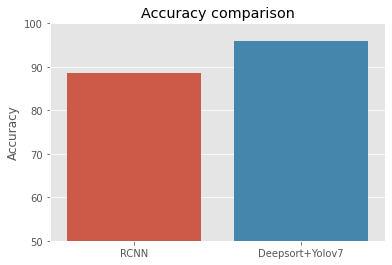

In [10]:
import numpy as np
import seaborn as sns
import matplotlib as plt

plt.style.use('ggplot')
x=['RCNN','Deepsort+Yolov7']
 
ax=sns.barplot(x,ac)
ax.set_title('Accuracy comparison')
ax.set_ylabel('Accuracy')
#ax.yaxis.set_major_locator(ticker.LinearLocator())
print("the accuracy of {} is {} and {} is {}".format(x[0],ac[0],x[1],ac[1]))
ax.set_ylim(50,100)
import pandas as pd
data={'Agorithms':x,
     "accuracy":ac}
df=pd.DataFrame(data)
df.head()








In [11]:
import cv2

import numpy as np

from time import sleep



largura_min = 80

altura_min = 80

offset = 6

pos_linha = 550



# FPS to vídeo

delay = 60



detec = []

carros = 0



	

def pega_centro(x, y, w, h):

    x1 = int(w / 2)

    y1 = int(h / 2)

    cx = x + x1

    cy = y + y1

    return cx, cy







cap = cv2.VideoCapture('video.mp4')



subtracao = cv2.bgsegm.createBackgroundSubtractorMOG()


frame=open('yolov7.pt','rb')
while True:

    ret, frame1 = cap.read()        

    tempo = float(1/delay)         

    sleep(tempo)         

    grey = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)         

    blur = cv2.GaussianBlur(grey, (3, 3), 5)          

    img_sub = subtracao.apply(blur)          

    dilat = cv2.dilate(img_sub, np.ones((5, 5)))           

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))           



    dilatada = cv2.morphologyEx(dilat, cv2. MORPH_CLOSE, kernel)          

    dilatada = cv2.morphologyEx(dilatada, cv2. MORPH_CLOSE, kernel)          





    contorno, h = cv2.findContours(dilatada, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)          





 

    cv2.line(frame1, (25, pos_linha), (1200, pos_linha), (176, 130, 39), 2)            

    for(i, c) in enumerate(contorno):            

        (x, y, w, h) = cv2.boundingRect(c)                

        validar_contorno = (w >= largura_min) and (h >= altura_min)                 

        if not validar_contorno:                 

            continue                      



        cv2.rectangle(frame1, (x, y), (x+w, y+h), (0, 255, 0), 2)                    

        centro = pega_centro(x, y, w, h)                    

        detec.append(centro)                     

        cv2.circle(frame1, centro, 4, (0, 0, 255), -1)                    



        for (x, y) in detec:                 

            if (y < (pos_linha + offset)) and (y > (pos_linha-offset)):                         

                carros += 1                          

                cv2.line(frame1, (25, pos_linha), (1200, pos_linha), (0, 127, 255), 3)                         

                detec.remove((x, y))                        

                print("No. of cars detected : " + str(carros))                        





    cv2.putText(frame1, "VEHICLE COUNT : "+str(carros), (320, 70),              
                cv2.FONT_HERSHEY_COMPLEX, 2, (0, 0, 255), 4)

    cv2.imshow("Video Original", frame1)

    cv2.imshow(" Detectar ", dilatada)



    if cv2.waitKey(1) == 27:

        break        

    

cv2.destroyAllWindows()

cap.release()

No. of cars detected : 1
No. of cars detected : 2
No. of cars detected : 3
No. of cars detected : 4
No. of cars detected : 5
No. of cars detected : 6
